In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
# import os
# path = "/content/drive/Shareddrives/covid.eng.pdn.ac.lk drive/COVID-AI (PG)/spatio_temporal/Covid19_DL_Forecasting_Codes"
# os.chdir(path)

In [12]:
import sys
import os
import time
sys.path.insert(0, os.path.join(sys.path[0], '..'))
import pandas as pd  # Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
# import gluonts
from math import sqrt

# data manipulation and signal processing
import math
import scipy
from scipy import signal
import scipy.stats as ss

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import folium

# path = "/con

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones

from utils.metrics import evaluate
from utils.plots import bar_metrics, plot_prediction
from utils.functions import distance, normalize_for_nn, undo_normalization
from utils.data_loader import load_data, per_million, get_daily
from utils.smoothing_functions import O_LPF,NO_LPF,O_NDA,NO_NDA
from utils.data_splitter import split_on_region_dimension, split_on_time_dimension,split_into_pieces_inorder

from random import random
from datetime import datetime
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook


#Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

2.4.1


Required variables:

*   **region_names** - Names of the unique regions.
*   **confirmed_cases** - 2D array. Each row should corresponds to values in 'region_names'. Each column represents a day. Columns should be in ascending order. (Starting day -> Present)
*   **daily_cases** - confirmed_cases.diff()
*   **population** - Population in 'region'
*   **features** - Features of the regions. Each column is a certain feature.
*   **START_DATE** - Starting date of the data DD/MM/YYYY
*   **n_regions** Number of regions



In [13]:
daily_data = True
DATASET = "Sri Lanka" #"Sri Lanka" "Texas" "USA" "Global"
split_date = '2021-02-01'

EPOCHS = 100
BATCH_SIZE = 16
BUFFER_SIZE = 100
WINDOW_LENGTH = 14
PREDICT_STEPS = 7
lr = 0.002
TRAINING_DATA_TYPE = "Filtered" #"Filtered"


d = load_data(DATASET,path="../Datasets")
region_names=d["region_names"] 
confirmed_cases=d["confirmed_cases"] 
daily_cases=d["daily_cases"] 
features=d["features"] 
START_DATE=d["START_DATE"] 
n_regions=d["n_regions"] 
daily_cases[daily_cases<0] = 0
population = features["Population"]
for i in range(len(population)):
    print("{:.2f}%".format(confirmed_cases[i,:].max()/population[i]*100), region_names[i])

days = confirmed_cases.shape[1]
n_features = features.shape[1]

print(f"Total population {population.sum()/1e6:.2f}M, regions:{n_regions}, days:{days}")

daily_filtered = O_LPF(daily_cases, datatype='daily', order=3, R_weight=1.0, EIG_weight=1, corr = True, region_names=region_names)

daily_per_mio_capita = per_million(daily_cases,population)
daily_per_mio_capita_filtered = per_million(daily_filtered,population)


df = pd.DataFrame(daily_cases.T,columns = features.index)
df.index = pd.to_datetime(pd.to_datetime(START_DATE).value + df.index*24*3600*1000000000)


df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('../Datasets/training.csv')
df_test.to_csv('../Datasets/test.csv')

split_days = (pd.to_datetime(split_date)-pd.to_datetime(START_DATE)).days



(25, 126)
['AMPARA', 'ANURADHAPURA', 'BADULLA', 'BATTICOLOA', 'COLOMBO', 'GALLE', 'GAMPAHA', 'HAMBANTOTA', 'JAFFNA', 'KALUTARA', 'KANDY', 'KEGALLE', 'KILINOCHCHI', 'KURUNEGALA', 'MANNAR', 'MONERAGALA', 'MATALE', 'MATARA', 'MULLATIVU', 'NUWARAELIYA', 'POLONNARUWA', 'PUTTALAM', 'RATNAPURA', 'TRINCOMALEE', 'VAVUNIA']
Index(['AMP', 'ANU', 'BAD', 'BAT', 'COL', 'GAL', 'GAM', 'HAM', 'JAF', 'KAL',
       'KAN', 'KEG', 'KIL', 'KUR', 'MAN', 'MON', 'MTL', 'MTR', 'MUL', 'NUW',
       'POL', 'PUT', 'RAT', 'TRI', 'VAN'],
      dtype='object', name='Code')
0.04% AMPARA
0.06% ANURADHAPURA
0.17% BADULLA
0.10% BATTICOLOA
1.21% COLOMBO
0.21% GALLE
0.73% GAMPAHA
0.10% HAMBANTOTA
0.07% JAFFNA
0.51% KALUTARA
0.28% KANDY
0.19% KEGALLE
0.10% KILINOCHCHI
0.15% KURUNEGALA
0.26% MANNAR
0.11% MONERAGALA
0.19% MATALE
0.20% MATARA
0.04% MULLATIVU
0.17% NUWARAELIYA
0.05% POLONNARUWA
0.15% PUTTALAM
0.23% RATNAPURA
0.12% TRINCOMALEE
0.21% VAVUNIA
Total population 21.44M, regions:25, days:126
80 days of training data 


In [14]:
from models import get_model
MODEL_TYPE = "LSTM4EachDay_WO_Regions"
model, reduce_regions2batch = get_model(MODEL_TYPE,
                                            input_days=WINDOW_LENGTH,
                                            output_days=PREDICT_STEPS,
                                            n_features=n_features,
                                            n_regions=n_regions)

Model: "LSTM4EachDay_WO_Regions"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq (InputLayer)          [(None, 14, 1)]      0                                            
__________________________________________________________________________________________________
lstm_14 (LSTM)                  (None, 7)            252         input_seq[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem_28 (Sl (None, 1)            0           lstm_14[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_29 (Sl (None, 13, 1)        0           input_seq[0][0]                  
____________________________________________________________________________

In [ ]:
x_rand = np.random.



### Preparing data for training

In [6]:
def get_data(filtered, normalize=False):
    if filtered == False:
        x,y= np.copy(daily_cases), np.copy(daily_cases)
    else:
        x,y= np.copy(daily_filtered), np.copy(daily_filtered)
    
    
    x = per_million(x, population)
    y = per_million(y, population)
    if normalize:
        
        x, xs=normalize_for_nn(x, None if type(normalize)==bool else normalize)
        y, xs=normalize_for_nn(y, xs)
        return x.T,y.T,xs
    else:
        return x.T,y.T

In [7]:


x_data, y_data, x_data_scalers = get_data(False,normalize=True)
x_dataf, y_dataf, x_data_scalersf = get_data(True, normalize=True)

x_data, y_data, _ = get_data(TRAINING_DATA_TYPE=="Filtered",normalize=x_data_scalers)

features = np.zeros((n_regions,0))


tmp = split_on_time_dimension(x_data.T, y_data.T, features, WINDOW_LENGTH, PREDICT_STEPS, 
                              k_fold=3, test_fold=2, reduce_last_dim=reduce_regions2batch,
                              only_train_test=True, debug=True)
X_train, X_train_feat, Y_train, X_val, X_val_feat, Y_val, X_test, X_test_feat, Y_test = tmp

if len(X_train.shape) == 2:
    X_train, X_train_feat, Y_train = np.expand_dims(X_train,-1),np.expand_dims(X_train_feat,-1),np.expand_dims(Y_train,-1)
    X_val, X_val_feat, Y_val = np.expand_dims(X_val,-1),np.expand_dims(X_val_feat,-1),np.expand_dims(Y_val,-1)
    X_test, X_test_feat, Y_test = np.expand_dims(X_test,-1),np.expand_dims(X_test_feat,-1),np.expand_dims(Y_test,-1)

print("Train", X_train.shape, Y_train.shape, X_train_feat.shape)
print("Val", X_val.shape, Y_val.shape, X_val_feat.shape)
print("Test", X_test.shape, Y_test.shape,X_test_feat.shape)

X_train = np.concatenate([X_train, X_test], 0)
X_train_feat = np.concatenate([X_train_feat, X_test_feat], 0)
Y_train = np.concatenate([Y_train, Y_test], 0)

print("Train", X_train.shape, Y_train.shape, X_train_feat.shape)
print("Val", X_val.shape, Y_val.shape, X_val_feat.shape)


NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)

k_folds 3
samples per fold 41
0, val start a=82, test start b=82, test end c=123, 125
x_train:(25, 82) y_train:(25, 82) x_val:(25, 0) y_val:(25, 0) x_test:(25, 41) y_test:(25, 41)
selecting 84 samples from training part
selecting 41 samples from validation part
selecting 41 samples from testing part
Train (2100, 14, 1) (2100, 7, 1) (2100, 0, 1)
Val (0, 14, 1) (0, 7, 1) (0, 0, 1)
Test (1025, 14, 1) (1025, 7, 1) (1025, 0, 1)
Train (3125, 14, 1) (3125, 7, 1) (3125, 0, 1)
Val (0, 14, 1) (0, 7, 1) (0, 0, 1)


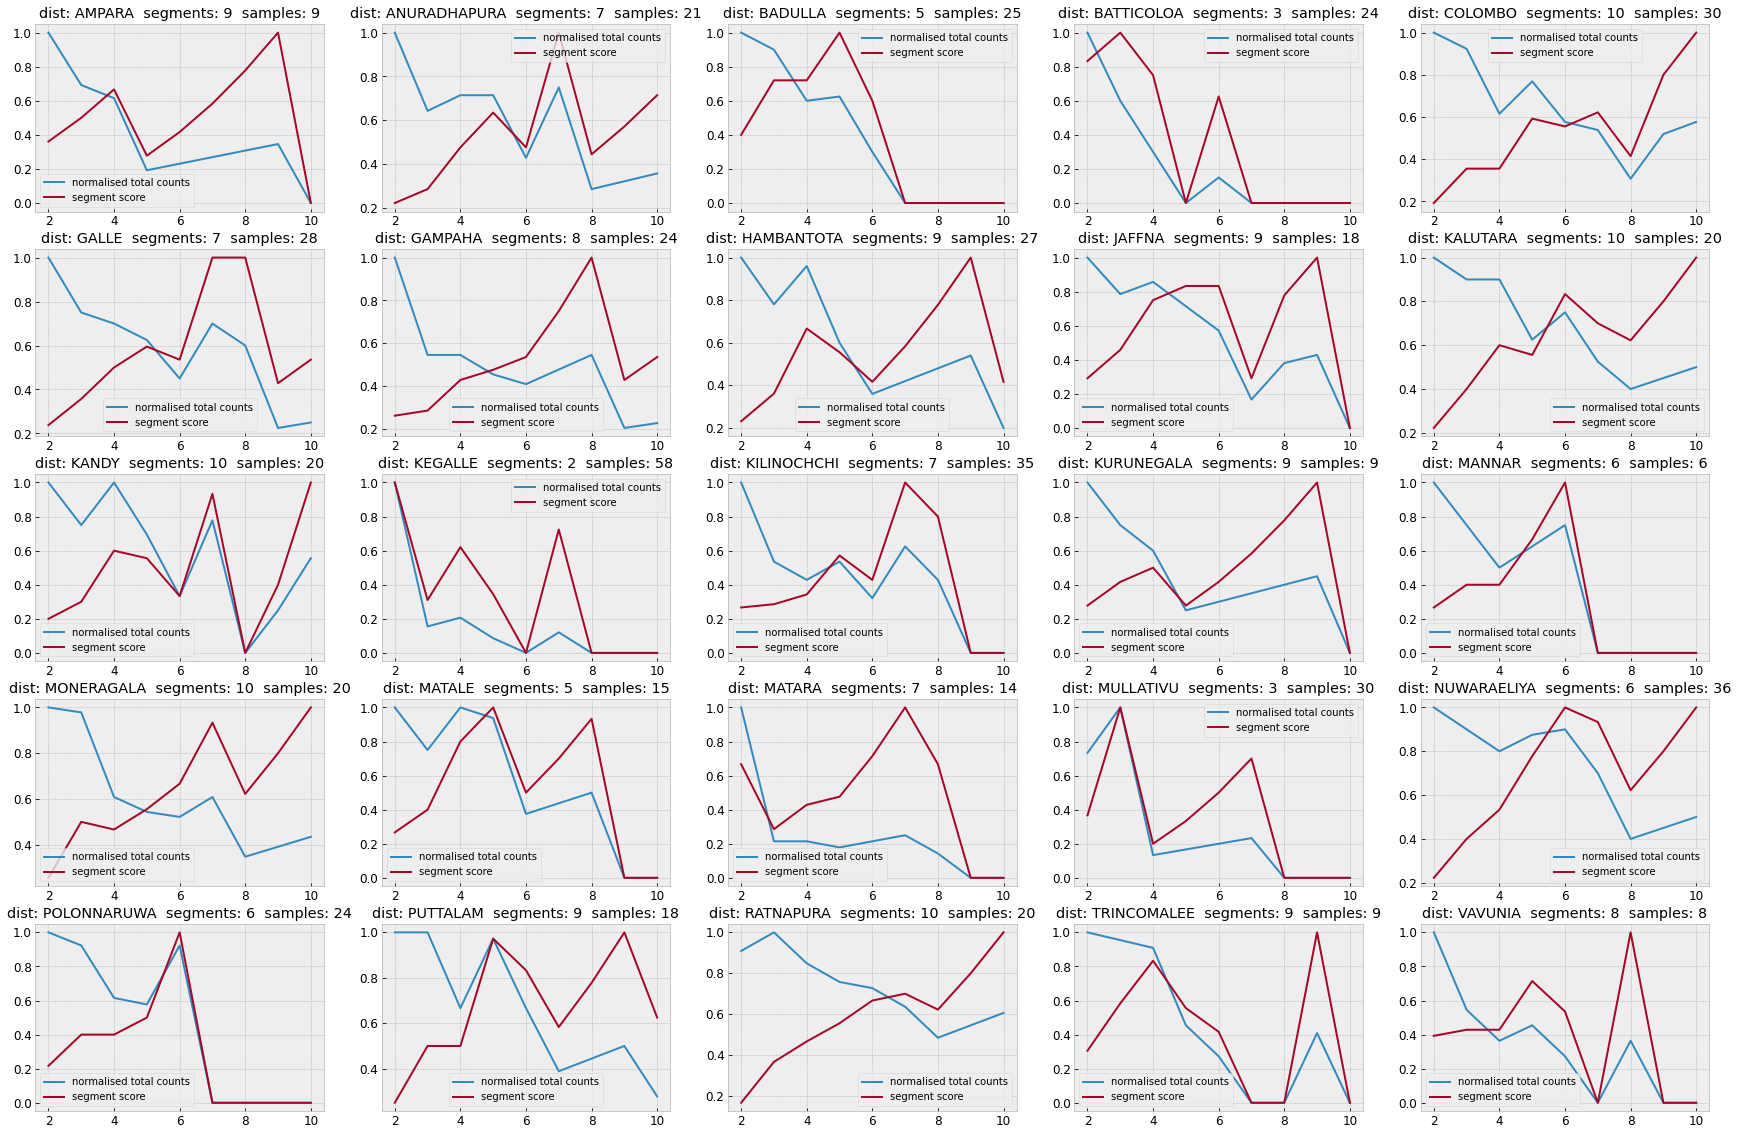

segments per district=  [ 9  7  5  3 10  7  8  9  9 10 10  2  7  9  6 10  5  7  3  6  6  9 10  9
  8]
25
AMPARA [31. 41. 42. 44. 45. 47. 50. 58. 55.]
ANURADHAPURA [27. 12. 10. 16. 14. 23. 51. 30. 33. 42. 49. 43. 41. 40. 38. 58. 57. 56.
  2.  0.  1.]
BADULLA [41. 47. 48.  2. 36. 50. 51. 46. 27. 28.  6. 52.  7. 23.  8. 14. 19. 20.
 22.  9. 18. 15. 10. 58. 56.]
BATTICOLOA [ 5. 11.  3. 18. 21.  6.  7. 31. 41. 57. 40. 38. 39. 37. 42. 36. 49. 53.
 46. 51. 48. 50. 58. 45.]
COLOMBO [43. 48. 46. 52. 53. 54. 36. 34. 35. 31. 33. 32.  5. 29.  3.  0.  2. 28.
 25.  6.  9. 11. 10. 24. 22. 13. 12. 17. 16. 18.]
GALLE [12.  9.  8. 10.  0. 17. 14. 15. 33. 22. 38. 19. 25. 32. 23. 39. 45. 50.
 48. 47. 53. 52. 54. 49. 57. 55. 58. 56.]
GAMPAHA [ 0.  1.  2.  4.  5.  3.  9. 10.  6. 13. 33. 49. 25. 24. 43. 51. 50. 52.
 53. 54. 55. 58. 56. 57.]
HAMBANTOTA [ 1.  9. 10. 26. 27. 25. 33. 28. 35. 38. 12. 11. 40. 41. 20. 42. 24. 43.
 47. 48. 46. 50. 54. 53. 57. 58. 56.]
JAFFNA [ 7. 10. 57. 53. 49. 56. 48. 42. 39. 47. 

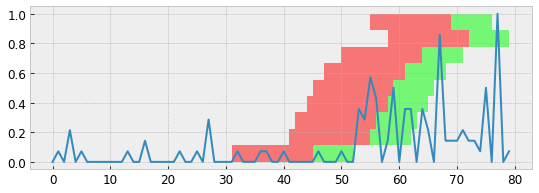

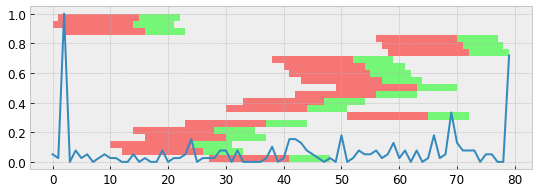

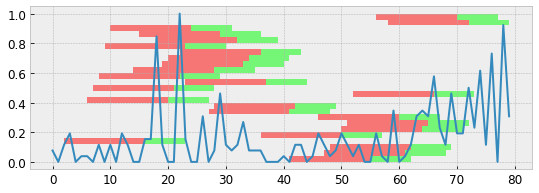

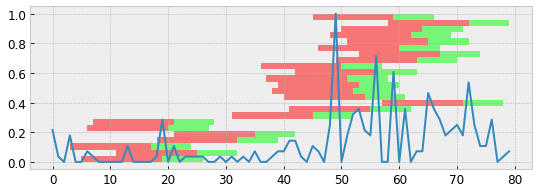

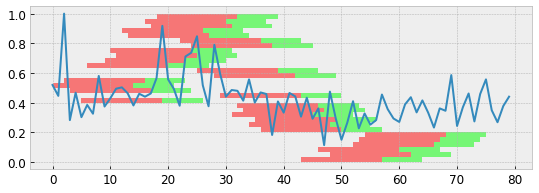

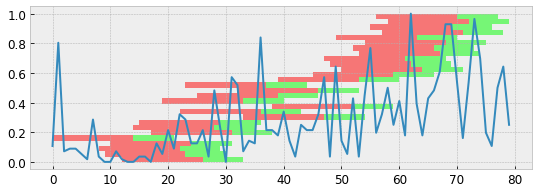

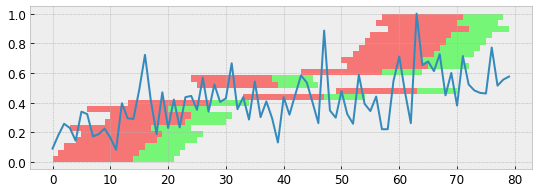

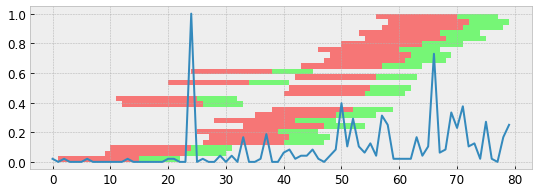

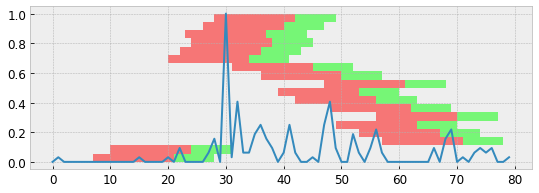

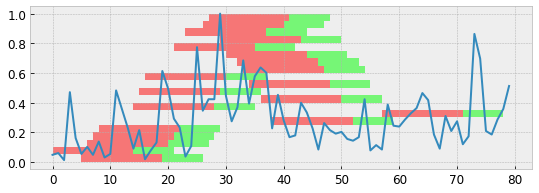

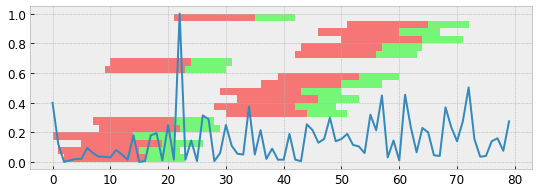

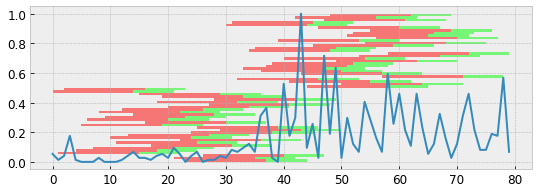

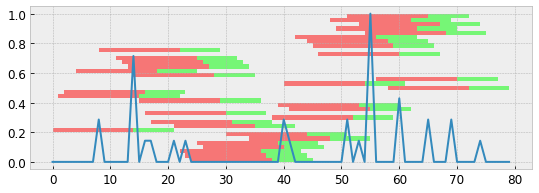

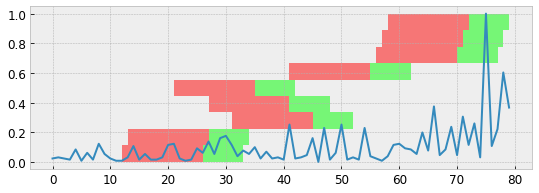

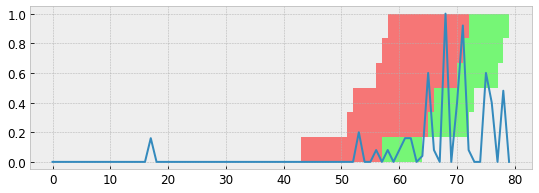

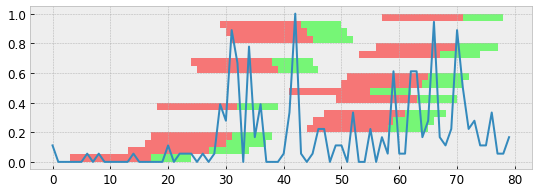

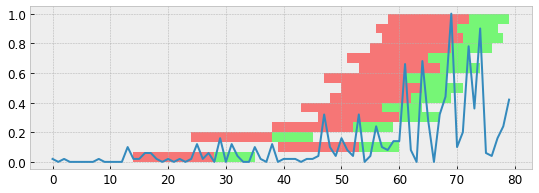

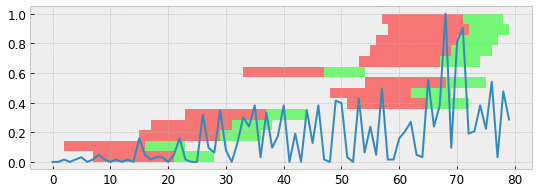

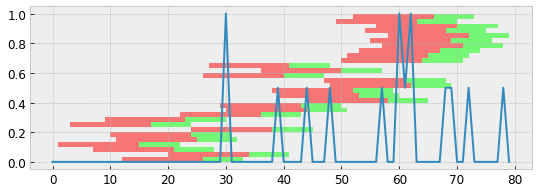

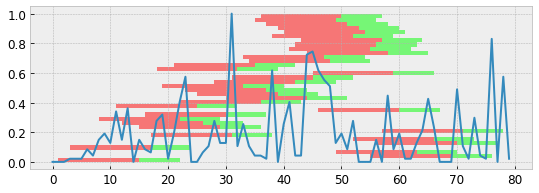

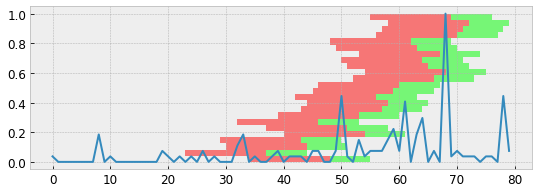

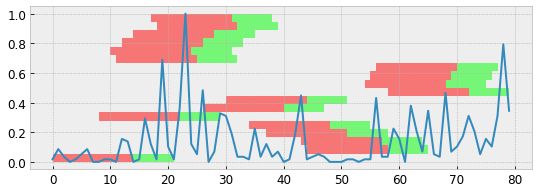

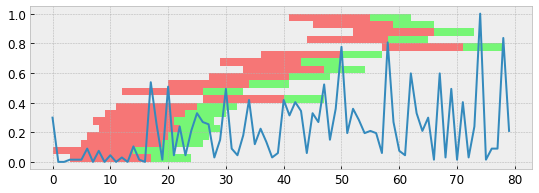

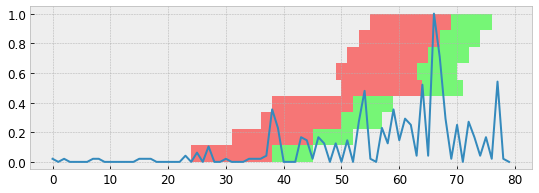

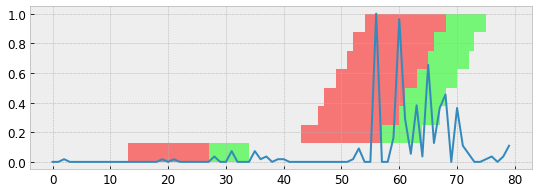

In [8]:
import random

import matplotlib.patches as patches

def get_count(segments, data):
    bounds = []
    count = []
    idx = []
    for i in range(segments):
        data = (data - np.amin(data))
        bounds.append(np.round((i+1)*np.amax(data)/segments,3))
        if i==0:
            ineq = data <= bounds[i]
        elif i==(segments-1):
            ineq = data > bounds[i-1]
        else:
            ineq = (data > bounds[i-1])*(data <= bounds[i])
        count.append(np.sum(ineq))
        idx.append(np.reshape(np.array(np.where(ineq)),[-1,]))
    count = np.array(count).astype(int)
    bounds = np.array(bounds).astype(np.float64)
    return count, bounds, idx

dataset = df_training.values.T
dataset_norm = np.zeros_like(dataset)
for i in range(daily_cases.shape[0]):
    dataset_norm[i,:] = dataset[i,:]/np.amax(dataset[i,:])

alldata_train = dataset_norm

samples_all = np.zeros([alldata_train.shape[0], alldata_train.shape[1]-WINDOW_LENGTH-PREDICT_STEPS, WINDOW_LENGTH])
samples_mean = np.zeros([alldata_train.shape[0], alldata_train.shape[1]-WINDOW_LENGTH-PREDICT_STEPS])

# evaluating optimal number of segments for each district
segment_array = [2,3,4,5,6,7,8,9,10]
segment_dist = []
plt.figure(figsize=(5*6,5*4))
for i in range(samples_all.shape[0]):
    for k in range(samples_all.shape[1]):
        samples_all[i,k,:] = alldata_train[i,k:k+WINDOW_LENGTH]
        samples_mean[i,k] = np.mean(samples_all[i,k,:])
    all_counts = []
    count_score = []
    # evaluating the count score for each district
    for n in range(len(segment_array)):    
        segments = segment_array[n]
        [count, bounds, idx] = get_count(segments, samples_mean[i,:])              
        all_counts.append(np.amin(count)*len(count))
        count_score.append((all_counts[n]**1)*(n+1))
    
    plt.subplot(5,5,i+1)
    plt.plot(segment_array,all_counts/np.amax(all_counts),linewidth=2)
    plt.plot(segment_array,count_score/np.amax(count_score),linewidth=2)
    plt.legend(['normalised total counts','segment score'])
    plt.title('dist: '+region_names[i]+'  segments: '+str(segment_array[np.argmax(count_score)])+'  samples: '+str(all_counts[np.argmax(count_score)]))
    segment_dist.append(segment_array[np.argmax(count_score)]) 
segment_dist = np.array(segment_dist).astype(int)

plt.show()

print('segments per district= ', segment_dist)

idx_rand_all = []
for i in range(samples_all.shape[0]):
    data = samples_mean[i,:]
    segments = segment_dist[i]
    [count_dist, bounds_dist, idx_dist] = get_count(segments, data)
    n_per_seg = np.amin(count_dist)
    data_new = []
    idx_rand = np.zeros([segments,n_per_seg])
    for k in range(segments):
        idx_temp = list(idx_dist[k])
        idx_rand[k,:] = random.sample(idx_temp,n_per_seg)
    idx_rand = np.reshape(idx_rand, [-1,])
    idx_rand_all.append(idx_rand)
print(len(idx_rand_all))

x_train_opt, y_train_opt = [], []
# undersampling using optimal number of segments
for i in range(samples_all.shape[0]):
    data = samples_mean[i,:]
    segments = segment_dist[i]
    [count_dist, bounds_dist, idx_dist] = get_count(segments, data)
    n_per_seg = np.amin(count_dist)
    data_new = []
    idx_rand = np.zeros([segments,n_per_seg])
    for k in range(segments):
        idx_temp = list(idx_dist[k])
#         print(idx_temp)
        idx_rand[k,:] = random.sample(idx_temp,n_per_seg)
    idx_rand = np.reshape(idx_rand, [-1,])
    print(region_names[i], idx_rand)
    
    
    
    
    fig, ax = plt.subplots(figsize=(9,3))
    ax.plot(alldata_train[i])
    for j,idx in enumerate(idx_rand):
        idx=int(idx)
        
        rect = patches.Rectangle((idx, j/len(idx_rand)), WINDOW_LENGTH, 1/len(idx_rand), linewidth=1, edgecolor=None, facecolor=(1.,0.,0.,0.5))
        ax.add_patch(rect)
        rect = patches.Rectangle((idx+WINDOW_LENGTH, j/len(idx_rand)), PREDICT_STEPS, 1/len(idx_rand), linewidth=1, edgecolor=None, facecolor=(0.,1.,0.,0.5))
        ax.add_patch(rect)
        
        x_train_opt.append(alldata_train[i, idx:idx+WINDOW_LENGTH])
        y_train_opt.append(alldata_train[i, idx+WINDOW_LENGTH:idx+WINDOW_LENGTH+PREDICT_STEPS])
    plt.show()
    
x_train_opt = np.array(x_train_opt)
y_train_opt = np.array(y_train_opt)

x_train_opt = np.expand_dims(x_train_opt,-1)
y_train_opt = np.expand_dims(y_train_opt,-1)

In [ ]:
X_train.shape,Y_train.shape

In [ ]:
x_train_opt.shape,y_train_opt.shape

In [10]:
if reduce_regions2batch:  # Currently optimal undersampling supports independatly on regions.
    X_train = x_train_opt
    Y_train = y_train_opt

train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_data = test_data.batch(BATCH_SIZE)

freq, xcheck = np.histogram(np.concatenate(X_train,-1).mean(0))

NORMALIZING; Data: (25, 125) expected (regions, days)
NORMALIZING; Data: (25, 125) expected (regions, days)


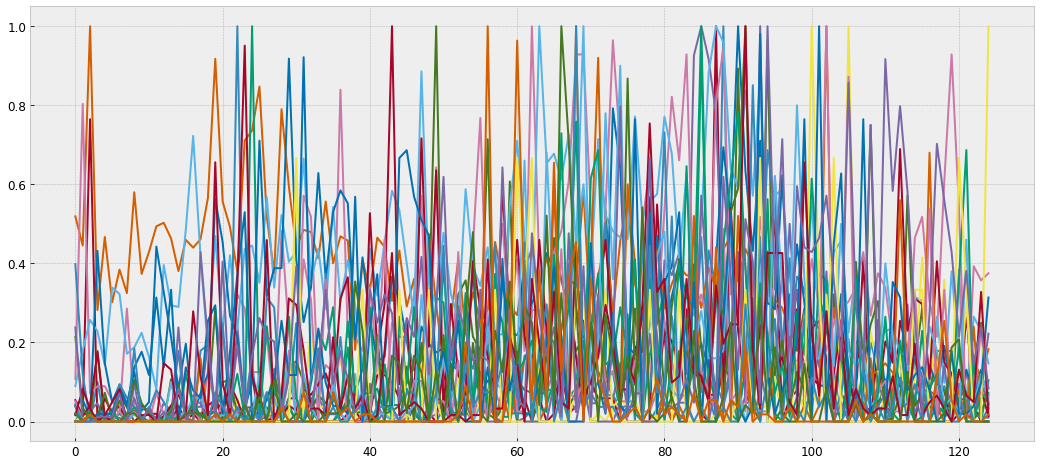

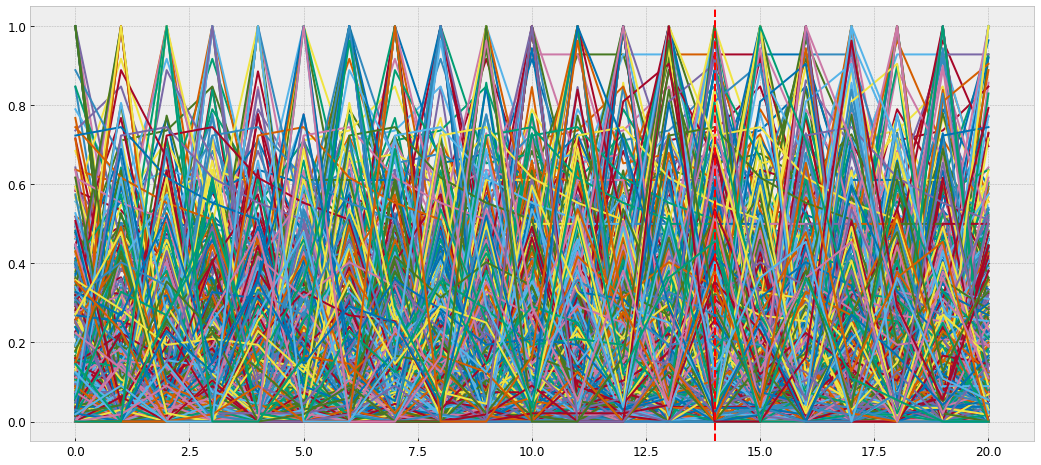

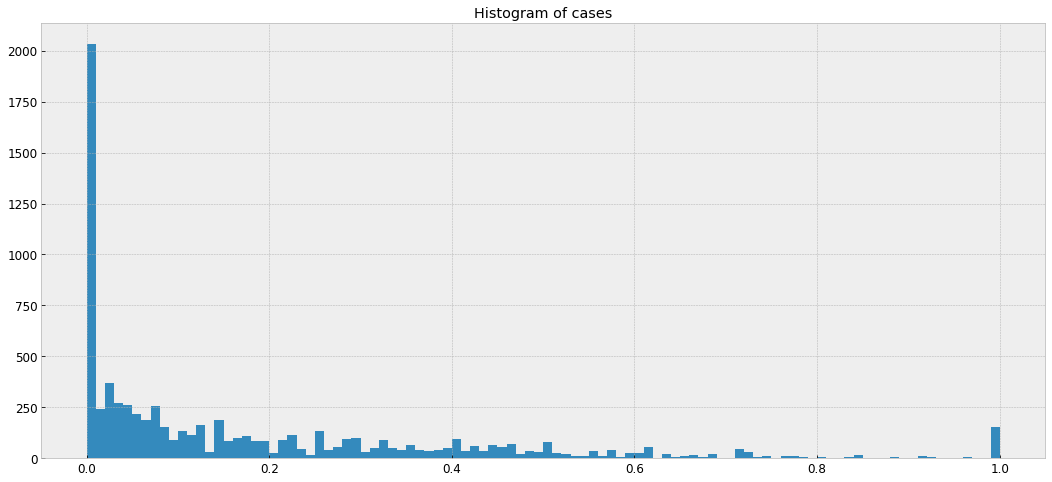

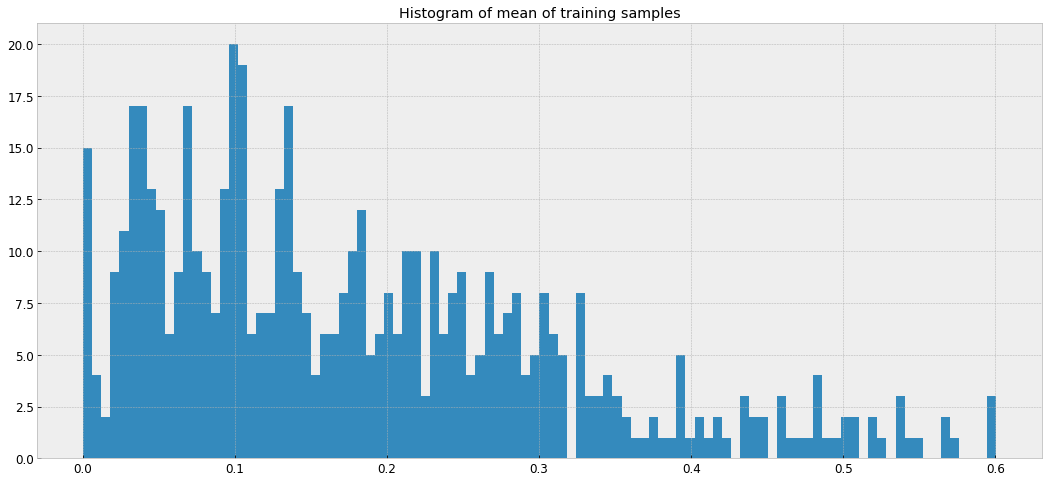

In [11]:
x_data, y_data, _ = get_data(filtered=False, normalize=True)
plt.plot(x_data)
plt.show()

for i in range(X_train.shape[-1]):
    plt.plot(np.concatenate([X_train[:,:,i],Y_train[:,:,i]],1).T)
plt.axvline(X_train.shape[1],color='r',linestyle='--')
plt.show()

plt.hist(X_train.reshape(-1), bins=100)
plt.title("Histogram of cases")
plt.show()

plt.hist(np.concatenate(X_train,-1).mean(0), bins=100)
plt.title("Histogram of mean of training samples")
plt.show()


## Train

In [ ]:
(1/np.log(freq))**3*10

In [ ]:
# # Mean Squared Error
   

# def loss_f(y_true, y_pred, x):
#     return mse(y_true, y_pred)

# Mean squared error with boosting low frequency samples
def bs(arr, v):
    l, r = 0, len(arr)
    while r - l > 0:
        i = (r + l) // 2
        if arr[i] < v:
            l = i+1
        elif arr[i] > v:
            r = i
        else:
            return i
    return l

def loss_f(y_true, y_pred, x):
    region_sample_freq = np.zeros((x.shape[0], x.shape[-1]), dtype='double')

    for batch in range(x.shape[0]):
        for n in range(x.shape[-1]):
            i = bs(xcheck, np.mean(x[batch,:,n]))-1
            region_sample_freq[batch,n] = freq[i]
    y_pred = tf.dtypes.cast(y_pred, tf.float64)
    mse = tf.reduce_mean((y_true - y_pred)**2, 1)
    
    return tf.reduce_mean(mse*(1/np.log(region_sample_freq))**2*10)

In [ ]:
fmodel_name = DATASET + "_" + MODEL_TYPE + "_" + TRAINING_DATA_TYPE

print(fmodel_name)
print("Train", X_train.shape, Y_train.shape, X_train_feat.shape)
print("Val", X_val.shape, Y_val.shape, X_val_feat.shape)
print("Test", X_test.shape, Y_test.shape,X_test_feat.shape)


folder = time.strftime('%Y.%m.%d-%H.%M.%S', time.localtime())+"_"+fmodel_name
os.makedirs('./logs/' + folder)
tensorboard = TensorBoard(log_dir='./logs/' + folder, write_graph=True, histogram_freq=1, write_images=True)
tensorboard.set_model(model)


opt = tf.keras.optimizers.Adam(lr=lr)
def eval_metric(y_true, y_pred):  
    
    return np.mean((np.squeeze(y_true)-np.squeeze(y_pred))**2)**0.5

train_metric = []
val_metric = []
test_metric = []
best_test_value = 1e10
for epoch in range(EPOCHS):
    losses = []
    for x,y in train_data:
        plt.show()
        with tf.GradientTape() as tape:
            y_pred = model(x, training=True)
            loss = loss_f(y, y_pred, x)

        grad = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grad, model.trainable_variables))
        losses.append(loss)

        print(f"\r Epoch {epoch}: mean loss = {np.mean(losses):.5f}", end='')
    # add metric value of the prediction (from training data)
    pred_train_y = model(X_train, training=False)
    train_metric.append(eval_metric(Y_train,pred_train_y))
    # add metric value of the prediction (from testing data)
    pred_test_y = model(X_test, training=False)
    test_metric.append(eval_metric(Y_test,pred_test_y))
    
    if test_metric[-1] < best_test_value:
        best_test_value = test_metric[-1]
        print(f" Best test metric {best_test_value}. Saving model...")
        model.save("temp.h5")

In [ ]:
freq

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.ion()
plt.plot(train_metric, label='Train')
plt.plot(test_metric, label='Test')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.ioff()
plt.show()

In [ ]:
model =  tf.keras.models.load_model("temp.h5")
model.save("models/"+fmodel_name+".h5")

In [ ]:
def get_model_predictions(model,x_data,y_data, scalers):
    print(f"Predicting from model. X={x_data.shape} Y={y_data.shape}")
    # CREATING TRAIN-TEST SETS FOR CASES
    x_test, y_test = split_into_pieces_inorder(x_data.T,y_data.T, WINDOW_LENGTH, PREDICT_STEPS, WINDOW_LENGTH+PREDICT_STEPS,
                                               reduce_last_dim=False)
    print("Input data shape", x_test.shape)
    if model.input.shape[-1]==1:
        y_pred = np.zeros_like(y_test)
        for i in range(len(region_names)):
            y_pred[:,:,i] = model(x_test[:,:,i:i+1])
    else:
        y_pred = model(x_test).numpy()
    print("Predicted shape", y_pred.shape)
    # # NOTE:
    # # max value may change with time. then we have to retrain the model!!!!!!
    # # we can have a predefined max value. 1 for major cities and 1 for smaller districts
    x_test = undo_normalization(x_test, scalers)
    y_test = undo_normalization(y_test, scalers)
    y_pred = undo_normalization(y_pred, scalers)

    return x_test, y_test, y_pred

x_data, y_data, _ = get_data(filtered=False, normalize=x_data_scalers)
x_test, y_test, y_pred = get_model_predictions(model,x_data,y_data, x_data_scalers)
x_data, y_data, _ = get_data(filtered=True, normalize=x_data_scalers)
x_testf, y_testf, y_predf = get_model_predictions(model,x_data,y_data, x_data_scalers)

Ys = np.stack([y_test, y_testf, y_pred,y_predf], 1)
method_list = ['Observations Raw',
               'Observations Filtered',
               'Predicted using raw data',
               'Predicted using Filtered data']
styles = {
    'X':{'Preprocessing':'Raw','Data':'Training', 'Size':2},
    'Xf':{'Preprocessing':'Filtered','Data':'Training', 'Size':2},
    'Observations Raw':{'Preprocessing':'Raw','Data':'Training', 'Size':2},
    'Observations Filtered':{'Preprocessing':'Filtered','Data':'Training', 'Size':2},
    'Predicted using raw data':{'Preprocessing':'Raw','Data':'Predicted using raw data', 'Size':4},
    'Predicted using Filtered data':{'Preprocessing':'Filtered','Data':'Predicted using Filtered data', 'Size':3},
    
}
x_data, y_data = get_data(filtered=False, normalize=False)
# region_mask = (np.mean(x_data,0) > 50).astype('int32')
region_mask = (np.arange(n_regions) == 4).astype('int32')

plt.figure(figsize=(20,10))
plot_prediction(x_test,x_testf, Ys, method_list, styles, region_names, region_mask)

plt.savefig(f"images/{DATASET}_{TRAINING_DATA_TYPE}.eps")
plt.savefig(f"images/{DATASET}_{TRAINING_DATA_TYPE}.jpg")
plt.show()


In [ ]:
def window_data(X,Y,window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x=[]
    y=[]
    for i in range(window-1,len(X)):
        x.append(X[i-window+1:i+1]) 
        y.append(Y[i])
    return np.array(x), np.array(y)

def get_model_predictions(model,x_data,y_data, scalers):
    print(f"Predicting from model. X={x_data.shape} Y={y_data.shape}")
    X_w,y_w = window_data(x_data,y_data,window=WINDOW_LENGTH)
    
    X_test_w = X_w[split_days-WINDOW_LENGTH-1:-1]
    y_test_w = y_w[split_days-WINDOW_LENGTH-1:-1]
    
    if model.input.shape[-1]==1:
        yhat = []
        for col in range(n_regions):
            yhat.append(model.predict(X_test_w[:,:,col:col+1])[:,0].reshape(1,-1)[0])
        yhat = np.squeeze(np.array(yhat)).T
    else:
        yhat = model.predict(X_test_w[:,:,:])[:,0].reshape(-1,n_regions)
        
   
    yhat = undo_normalization(yhat, scalers)[0]
    y_test_w = undo_normalization(y_test_w, scalers)[0]
    return X_test_w, y_test_w, yhat

x_data, y_data, _ = get_data(filtered=False, normalize=x_data_scalers)
_, y_test, yhat = get_model_predictions(model,x_data,y_data, x_data_scalers)
x_dataf, y_dataf, _ = get_data(filtered=True, normalize=x_data_scalers)
_, y_test, yhatf = get_model_predictions(model,x_dataf,y_dataf, x_data_scalers)

x_data, y_data = get_data(filtered=False, normalize=False)
x_dataf, y_dataf = get_data(filtered=True, normalize=False)
# X = np.expand_dims(x_data[split_days-WINDOW_LENGTH:split_days,:],0)
# Xf = np.expand_dims(x_dataf[split_days-WINDOW_LENGTH:split_days,:],0)
X = np.expand_dims(x_data[:split_days,:],0)
Xf = np.expand_dims(x_dataf[:split_days,:],0)
Y = y_data[split_days-1:,:]
Yf = y_dataf[split_days-1:,:]

Ys = [Y, Yf, yhat, yhatf]
method_list = ['Observations Raw',
               'Observations Filtered',
               f'Predictions using Raw data (Model {TRAINING_DATA_TYPE} {DATASET} data)',
               f'Predictions using Filtered data (Model {TRAINING_DATA_TYPE} {DATASET} data)',
               ]
styles = {
    'X':{'Preprocessing':'Raw','Data':'Training', 'Size':2},
    'Xf':{'Preprocessing':'Filtered','Data':'Training', 'Size':2},
    'Observations Raw':{'Preprocessing':'Raw','Data':'Training', 'Size':2},
    'Observations Filtered':{'Preprocessing':'Filtered','Data':'Training', 'Size':2},
    f'Predictions using Raw data (Model {TRAINING_DATA_TYPE} {DATASET} data)':{'Preprocessing':'Raw','Data':f'Predictions using Raw data (Model {TRAINING_DATA_TYPE} {DATASET} data)', 'Size':4},
    f'Predictions using Filtered data (Model {TRAINING_DATA_TYPE} {DATASET} data)':{'Preprocessing':'Filtered','Data':f'Predictions using Filtered data (Model {TRAINING_DATA_TYPE} {DATASET} data)', 'Size':3},
    
}
for i in range(len(Ys)):
    print(method_list[i],Ys[i].shape)
    Ys[i] = np.expand_dims(Ys[i],0)
Ys = np.stack(Ys, 1)

region_mask = ((200 > np.mean(x_data,0)) * (np.mean(x_data,0) > 00)).astype('int32')
# region_mask = (np.arange(n_regions) == 6).astype('int32')

plt.figure(figsize=(18,9))

plot_prediction(X,Xf, Ys, method_list, styles, region_names, region_mask)

plt.savefig(f"images/{DATASET}_DayByDay.eps")
plt.savefig(f"images/{DATASET}_DayByDay.jpg")
plt.show()

In [ ]:
x = WINDOW_LENGTH
r = model.input.shape[-1]
start_seqs = [np.random.random((1,x,r)),
              np.ones((1,x,r))*0,
              np.ones((1,x,r))*0.5,
              np.ones((1,x,r))*1,
              np.arange(x*r).reshape((1,x,r))/30,
              np.sin(np.arange(x)/x*np.pi/2).reshape((1,x,1)).repeat(r,-1)
]

predictions = []
for start_seq in start_seqs:
    input_seq = np.copy(start_seq)
    print(input_seq.shape)
    predict_seq = [start_seq[0,:,:]]
    for _ in range(50):
        output = model(input_seq, training=False)
        
        input_seq = input_seq[:,output.shape[1]:,:]
        if len(output.shape)==2:
            output = np.expand_dims(output,-1)
        predict_seq.append(output[0])
        input_seq = np.concatenate([input_seq, output],1)
    predictions.append(np.concatenate(predict_seq,0))


In [ ]:
plt.plot(1+np.array(predictions)[:,:30,0].T)
plt.show()
